# Introduction

This notebook is an introduction to the usage of the multiplex.py class constructed by Zeyad and Phil. It provides a brief explanation of the problem addressed by the class, as well as an illustration of some common tasks. It uses the Riyadh data as a standing illustration. 

This is very young software, so keep your eyes open! 

## Getting the software and data

The easiest way to follow along with this guide is to clone the whole repository in which it lies. Run the following at your terminal:

    git clone https://github.mit.edu/pchodrow/multiplex-metro.git

The repo includes both the relevant software (in the `metro` subdirectory) as well as our example data sets (in `1_data`) and some scripts that use the software (the \*.py files in the parent directory). 


Note that you will need to install the packages listed in `requirements.txt` in order to use this software. If you are using pip as your Python package manager, you can do this by running 

    pip install -r requirements.txt

in the directory in which you cloned the repository. 


# Problem Addressed

The `multiplex` class aspires to make it easy to work with multilayer networks in Python. Some tasks it handles include:

- Adding layers to a multiplex
- Linking the layers by proximity
- Reading and writing networks
- Summarizing a multilayer network
- Reading and keying and OD matrix
- Assigning flows on the multiplex based on an OD matrix

# How it works

The `multiplex` class is a fairly thin wrapper to the `networkx.DiGraph()` class. A multiplex `m` has three attributes:

- A `networkx.DiGraph()` which records the network structure
- A list `layers` of the distinct layers of the multiplex
- An optional `od` for use in assignment algorithms


# Using the class

Let's start by loading in the package and creating a multiplex. 

In [1]:
from metro import multiplex as mx
m = mx.multiplex()
m

<metro.multiplex.multiplex instance at 0x1c45368>

At first, `m` consists of an empty `networkx.DiGraph()` called `G`. `layers` is an empty list.  `od` is equal to `None`. 

In [2]:
m.__dict__ # show the properties of m

{'G': <networkx.classes.digraph.DiGraph at 0x1c42f50>,
 'layers': [],
 'od': None}

Another way to see what `m` has in it is to use the `m.summary()` method, which will list the layers and tell you whether or not `m` has an od matrix: 

In [3]:
m.summary()

OD: none 

layer           	nodes 	edges
----------------------------------------


Pretty boring so far! Let's add layers to our multiplex object. Each layer should be a networkx.DiGraph() object. Let's illustrate by reading in the Riyadh metro network. The `read_metro()` and `clean_metro()` functions are helpers to read in the metro and ensure it has the right features. 

In [4]:
from make_multiplex import *
metro = read_metro('1_data/metro', 'metro')
metro = clean_metro(metro)
type(metro)

117 nodes added to metro network
250 edges added to metro network.


networkx.classes.digraph.DiGraph

For its spatial methods, the `multiplex` class assumes that its networks have latitude given by a node attribute `lat` and longitude given by a node attribute `lon`. We can check that the metro has these properties by inspecting the nodes. `utility.nodes_2_df` creates a dataframe of node attributes for us to peak at:

In [5]:
from metro.utility import *
nodes_2_df(metro, attrs = ['Station', 'lat', 'lon']).head() 

,Station,lat,lon
0,1-15,24.663750,46.704642
1,1-14,24.668950,46.698373
2,1-17,24.648102,46.709414
3,1-16,24.657330,46.706193
4,1-11,24.707022,46.678645


Ok, looks good. Let's go ahead and add the street and TAZ networks too. 

In [6]:
streets = read_streets('1_data/street', 'street')
streets = clean_streets(streets)

taz = read_taz('1_data/taz', 'taz')
taz = clean_taz(taz)

10728 nodes added to street network
21524 edges added to street network.
4243 nodes added to TAZ connector network


The `clean_streets()` and `clean_taz` functions ensure that these networks have `lat` and `lon` attributes, as well as a few others that we use in the analysis. 

Great, we're ready to add layers. The easiest way to add layers is to create a `dict` layer names and their associated networks, and then use the `m.add_layers()` function. 

In [7]:
layer_dict = {'metro'   : metro,
              'streets' : streets,
              'taz'     : taz }
m.add_layers(layer_dict)
m.summary()

OD: none 

layer           	nodes 	edges
----------------------------------------
streets          	10728 	21508
metro            	117 	250
taz              	4243 	0


Now we're talking! We have three layers with the names we've given them, and the node and edge counts are shown. We can query the multiplex using nodes_2_df or edges_2_df. These functions also allow us to specify a layer:

In [8]:
m.nodes_2_df(layers = ['streets'], attrs = ['id', 'lat', 'lon'] ).head()

,id,lat,layer,lon
0,5499,24.785614,streets,46.831065
1,6901,24.786627,streets,46.795844
2,6902,24.750756,streets,46.681397
3,246,24.598586,streets,46.823456
4,5614,24.708366,streets,46.623886


In [9]:
m.edges_2_df(layers = ['metro'], attrs = ['dist_km'] ).head()

,dist_km,layer
0,3.267371,metro
1,3.889913,metro
2,1.436735,metro
3,1.155173,metro
4,1.710259,metro


If we ever need to access the underlying networkx.DiGraph() object, we can do this: 

In [10]:
N = m.layers_as_subgraph(m.get_layers())
len(N.node)

15088

# Connecting the multiplex

Ok, let's connect the layers. Currently, the only way to do this supplied by the multiplex class is a spatial join, which connects nodes of one layer to the nearest node of another layer. For example, the following code is what we use to connect the metro to the streets: 

In [11]:
m.spatial_join(layer1 = 'metro', # connect every node of metro
               layer2 = 'streets', # to the nearest node of streets
               transfer_speed = 1e10, # how fast the connection is traversed -- this is essentially 'free'
               base_cost = 0, # fixed waiting cost, e.g. average of 5 minutes for the train to come
               capacity = 1e10, # capacity of the connecting edge
               both = True) # bidirectional transfer

Added 117 bidirectional transfers between metro and streets.


If we now check summary, we'll see a new layer corresponding to the transfers: 

In [12]:
m.summary()

OD: none 

layer           	nodes 	edges
----------------------------------------
metro--streets   	0 	234
streets          	10728 	21508
metro            	117 	250
taz              	4243 	0


Let's now add the TAZ connectors. Note that this code will take significantly longer to run, since the underlying code of `m.spatial_join()` is pretty primitive. 

In [13]:
m.spatial_join(layer1 = 'taz', 
               layer2 = 'streets', 
               transfer_speed = 1e10, 
               base_cost = 0, 
               capacity = 1e10, 
               both = True, )

m.summary()

Added 4243 bidirectional transfers between taz and streets.
OD: none 

layer           	nodes 	edges
----------------------------------------
metro--streets   	0 	234
streets          	10728 	21508
metro            	117 	250
taz              	4243 	0
taz--streets     	0 	8486


This is all the assembly that we put into the multiplex for the Riyadh metro project. If you want to save your work, you can save the multiplex using the `m.to_txt()` function. The below code will save `m` in the `2_multiplex` folder as two files: `multiplex_example_nodes.txt` and `multiplex_example_edges.txt`.  

In [14]:
m.to_txt('2_multiplex', 'multiplex_example')

When we want to use the multiplex again in further analysis, we can read it in like this: 

In [15]:
m2 = mx.multiplex_from_txt(nodes_file_name = '2_multiplex/multiplex_example_nodes.txt',
                        edges_file_name = '2_multiplex/multiplex_example_edges.txt',
                        sep = '\t', 
                        nid = 'id', 
                        eidfrom = 'source', 
                        eidto = 'target')
m2.summary()        

OD: none 

layer           	nodes 	edges
----------------------------------------
metro--streets   	0 	234
taz              	4243 	0
streets          	10728 	21508
taz--streets     	0 	8486
metro            	117 	250


# ODs and ITA

Ok, we've got the network structure all set up. Now, let's load in an OD matrix and run ITA. The OD file should be a .txt or .csv file with three columns: `o`, `d`, and `flow`. Additionally, `o` and `d` should match an attribute of one layer of nodes in `m`. In this case, `o` and `d` match the `taz` attribute of the `taz` layer. 

In [16]:
m.nodes_2_df(layers = ['taz'], attrs = ['taz']).head()

,layer,taz
0,taz,152
1,taz,152
2,taz,908
3,taz,908
4,taz,643


We read in the file using the `m.read_od()` function: 

In [17]:
m.read_od(layer = 'taz', # keys are in this layer
          key = 'taz', # this is the key attribute
          od_file = '1_data/taz_od/0_1.txt', # here's where the file lives
          sep = ' ') # this is what separates entries

This command will likely take at least 2-3 minutes to run. Internally, Python is constructing a dict of dicts in the format 

    {o : {d : flow}}

This means that the flow between an origin `o` and a destination `d` can be rapidly retrieved using the syntax `od[o][d]`. The drawback is that constructing this dictionary requires quite a bit of memory, which is why it takes a while to read the OD. 

If we check out or multiplex, we'll see that the OD is loaded: 

In [18]:
m.summary()

OD: loaded

layer           	nodes 	edges
----------------------------------------
metro--streets   	0 	234
streets          	10728 	21508
metro            	117 	250
taz              	4243 	0
taz--streets     	0 	8486


As we'd expect, the multiplex has keys in the `taz` layer: 

In [19]:
m.od.keys()[:5]

['taz_10907', 'taz_10906', 'taz_10909', 'taz_10908', 'taz_903']

We can also check out the values: the code below shows the flows from the first entry of `od` to each of its destinations. 

In [20]:
m.od[m.od.keys()[0]]

{'taz_10907': 59.32,
 'taz_10906': 59.32,
 'taz_10909': 0.075555555555555556,
 'taz_10908': 0.075555555555555556,
 'taz_903': 0.023333333333333331,
 'taz_9767': 0.13666666666666666,
 'taz_4979': 1.4355555555555555,
 'taz_4973': 63.355833333333329,
 'taz_2629': 2.5500000000000003,
 'taz_10145': 0.024444444444444446,
 'taz_4545': 0.56083333333333341,
 'taz_2804': 0.030000000000000002,
 'taz_12983': 0.38666666666666666,
 'taz_12982': 0.38666666666666666,
 'taz_12987': 0.11222222222222222,
 'taz_12986': 0.11222222222222222,
 'taz_12984': 0.11222222222222222,
 'taz_10141': 1.1277777777777778,
 'taz_12989': 0.20666666666666667,
 'taz_12988': 0.20666666666666667,
 'taz_9935': 0.23888888888888887,
 'taz_4544': 0.56083333333333341,
 'taz_14353': 4.177777777777778,
 'taz_10588': 0.41666666666666669,
 'taz_5233': 1.0688888888888888,
 'taz_1593': 0.037777777777777778,
 'taz_1592': 0.037777777777777778,
 'taz_1595': 5.0241666666666669,
 'taz_1597': 5.0241666666666669,
 'taz_1596': 2.544999999999999

Note: Some methods of the multiplex class change the labels of nodes and edges. These methods will also re-key the OD matrix, so the network and multiplex won't get out of sync. Still, it's probably safest to load up the multiplex after you've done your other network transformations. 

Ok, why would we want an od matrix in the first place? To run ITA of course! The code below runs partial ITA for only the first 50 origins, and in only one iteration (i.e. `P = [1]`). The commented-out version runs a more realistic ITA with all nodes and 4 iterations. 

In [21]:
m.run_ita(n_nodes = 50, 
          summary = False, # change this to get route tables 
          attrname = 'congested_time_m',
          flow_name = 'flow',
          P = [1])

# m.run_ita(n_nodes = None, 
#           summary = False, # change this to get route tables 
#           attrname = 'congested_time_m',
#           flow_name = 'flow',
#           P = [.4, .3, .2, .1])

assignment for p = 1 completed in 0.1m


Internally, the `run_ita()` function converts the multiplex network into an igraph object and re-keys the OD accordingly. This is why you need the igraph package installed. Using the igraph package leads to significant performance improvements, but does require different syntax. Phil has tried to hide the igraph material behind the multiplex class, so that no one needs to interact with it directly. 

If we now inspect the multiplex, we'll find that the edges have 'congested_time_m' and 'flow' attributes: 

In [22]:
m.edges_2_df(layers = ['streets'], attrs = ['flow', 'congested_time_m']).head()

,congested_time_m,flow,layer
0,0.091489,NaN,streets
1,0.021935,NaN,streets
2,0.686156,3.427639,streets
3,0.712885,260.603125,streets
4,0.037431,72.814375,streets


The networkx package provides a powerful framework for visualizing networks. The following code plots a flow visualization, including streets and the metro: 

In [25]:
def get_coords(G):
    return {n : (G.node[n]['lon'], G.node[n]['lat']) for n in G}

def get_edge_scalar(G, attr):
    return np.array([G.edge[e[0]][e[1]][attr] for e in G.edges_iter()])

def flow_plot(multi, flow_attr, ax):
    G = multi.layers_as_subgraph(['streets'])
    nx.draw_networkx_edges(G, 
                           get_coords(G),
                           edge_color = 'grey',
                           width = 1,
                           arrows = False,
                           alpha = .2,
                           ax = ax)

    nx.draw_networkx_edges(G, 
                           get_coords(G),
                           edge_color = get_edge_scalar(G, flow_attr)/get_edge_scalar(G, 'capacity'),
                           width = get_edge_scalar(G, flow_attr) * .0003,
                           arrows = False,
                           edge_cmap = plt.get_cmap('plasma'),
                           edge_vmin = 0, 
                           edge_vmax = 1.5,
                           ax = ax)

    G = multi.layers_as_subgraph(['metro'])
    nx.draw_networkx_edges(G, get_coords(G),
            edge_color = 'white', 
            width = get_edge_scalar(G, flow_attr) * .0003,
            node_color = 'white',
            node_size = 0,
            alpha = .4,
            with_labels = False,
            arrows = False,
            ax = ax)

[(24.4833, 24.8833), (46.5167, 46.916700000000006)]

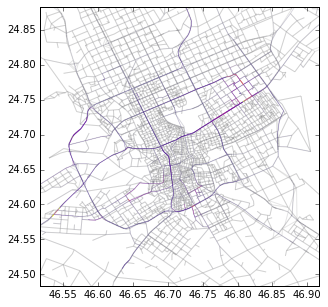

In [30]:
import matplotlib
matplotlib.use('Agg')
% matplotlib inline 

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
flow_plot(m, 'flow', ax)


center_point = (46.7167, 24.6333)
l = .2

xlim = (center_point[0] - l, center_point[0] + l)
ylim = (center_point[1] - l + .05, center_point[1] + l + .05)
ax.set(xlim = xlim, ylim = ylim)



Not the prettiest map, but it's not too hard to spruce it up in various ways. 

# Conclusions

There's some more functionality to see in the multiplex class, including more functions; parameters to functions you've already seen; and more visualization possibilities. Since this software is so young, documentation and other useful functionality is still a work in progress. 